In [1]:
import pandas as pd
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
import husl
from legendgram import legendgram
import mapclassify
from matplotlib_scalebar.scalebar import ScaleBar
from matplotlib.colors import ListedColormap
from shapely.geometry import Point

from tqdm import tqdm

In [2]:
clusters = pd.read_csv('/Users/martin/Dropbox/Academia/Data/Geo/Amsterdam/clustering/200309_clusters_complete_n30.csv', index_col=0)

In [3]:
clusters

,uID,cluster
0,0,15
1,1,15
2,2,15
3,3,15
4,4,15
...,...,...
252380,19452,12
252381,19453,12
252382,19454,22
252383,19455,22


In [4]:
years = pd.read_parquet('/Users/martin/Dropbox/Academia/Data/Geo/Amsterdam/raw/bag_data.pq')

In [7]:
years.columns

Index(['uID', 'bID', 'index_right', 'identificatie',
       'aanduidingrecordinactief', 'aanduidingrecordcorrectie', 'officieel',
       'inonderzoek', 'documentnummer', 'documentdatum', 'bouwjaar',
       'begindatumtijdvakgeldigheid', 'einddatumtijdvakgeldigheid',
       'gemeentecode', 'ground-0.00', 'ground-0.10', 'ground-0.20',
       'ground-0.30', 'ground-0.40', 'ground-0.50', 'roof-0.25', 'rmse-0.25',
       'roof-0.50', 'rmse-0.50', 'roof-0.75', 'rmse-0.75', 'roof-0.90',
       'rmse-0.90', 'roof-0.95', 'rmse-0.95', 'roof-0.99', 'rmse-0.99',
       'roof_flat', 'nr_ground_pts', 'nr_roof_pts', 'ahn_file_date',
       'ahn_version', 'height_valid', 'tile_id'],
      dtype='object')

In [5]:
years = years[['uID','bouwjaar']]

In [6]:
years['year'] = years['bouwjaar'].apply(lambda x: x[:4] if x else None)

In [7]:
years['year'].value_counts()

1005    7443
1990    4514
1960    4485
1930    4315
1970    3944
        ... 
1832       1
1823       1
1643       1
1834       1
1480       1
Name: year, Length: 387, dtype: int64

In [8]:
bins = [0, 1800, 1850, 1900, 1930, 1945, 1960, 1975, 1985, 1995, 2005, 2020]

In [9]:
years = years.dropna()
years['year'] = pd.cut(years['year'].astype(int), bins)

In [10]:
joined = clusters.merge(years[['uID', 'year']], on='uID', how='left')

In [11]:
joined.head(4)

,uID,cluster,year
0,0,15,"(1975, 1985]"
1,1,15,"(1975, 1985]"
2,2,15,"(1975, 1985]"
3,3,15,"(1985, 1995]"


In [12]:
buildings = gpd.read_file('/Users/martin/Dropbox/Academia/Data/Geo/Amsterdam/clustering/geometry.gpkg', layer='buildings')

In [13]:
buildings = buildings.merge(joined, on='uID', how='left')

In [33]:
buildings

,uID,bID,nID,nodeID,geometry,cluster,year
0,0,0.0,35435.0,13440.0,"POLYGON Z ((130331.253 483337.251 0.000, 13033...",15,"(1975, 1985]"
1,1,0.0,35435.0,13440.0,"POLYGON Z ((130374.022 483428.300 0.000, 13038...",15,"(1975, 1985]"
2,2,1.0,8112.0,10037.0,"POLYGON Z ((124352.680 476826.680 0.000, 12432...",15,"(1975, 1985]"
3,3,2.0,8112.0,10037.0,"POLYGON Z ((123803.120 476872.458 0.000, 12379...",15,"(1985, 1995]"
4,4,1.0,8112.0,10037.0,"POLYGON Z ((124354.600 476868.600 0.000, 12434...",15,"(1850, 1900]"
...,...,...,...,...,...,...,...
252679,252571,4099.0,6076.0,8462.0,"POLYGON Z ((123168.118 490375.432 0.000, 12316...",14,"(1930, 1945]"
252680,252572,5424.0,25037.0,9770.0,"POLYGON Z ((123096.733 490259.270 0.000, 12309...",14,"(1900, 1930]"
252681,252573,5423.0,21501.0,21867.0,"POLYGON Z ((123054.897 490248.150 0.000, 12304...",1,"(1900, 1930]"
252682,252574,5424.0,25037.0,23131.0,"POLYGON Z ((123097.931 490240.936 0.000, 12309...",14,"(1900, 1930]"


In [34]:
buildings.year.unique()

[(1975, 1985], (1985, 1995], (1850, 1900], (1960, 1975], (1995, 2005], ..., NaN, (1945.0, 1960.0], (1930.0, 1945.0], (0.0, 1800.0], (1800.0, 1850.0]]
Length: 12
Categories (11, interval[int64]): [(0, 1800] < (1800, 1850] < (1850, 1900] < (1900, 1930] ... (1975, 1985] < (1985, 1995] < (1995, 2005] < (2005, 2020]]

## plot

In [35]:
def north_arrow(f, ax, rotation=0, loc=2, legend_size=(.1,.1), frameon=False, thick=.1, outline=3, edgecolor='k', facecolor='k'):
    from legendgram.util import make_location
    from matplotlib.transforms import Affine2D
    
    arrpos = make_location(ax, loc, legend_size=legend_size)
    arrax = f.add_axes(arrpos)

    circle = plt.Circle((0, 0), radius=1, edgecolor=edgecolor, facecolor='w', linewidth=outline)
    arrax.add_patch(circle)

    rectangle = plt.Rectangle((-0.05, 0), thick, 1, facecolor=facecolor)
    t = Affine2D().rotate_deg(rotation) + arrax.transData
    rectangle.set_transform(t)
    arrax.add_patch(rectangle)
    arrax.axis('scaled')
    arrax.set_frame_on(frameon)
    arrax.get_yaxis().set_visible(False)
    arrax.get_xaxis().set_visible(False)
    return arrax

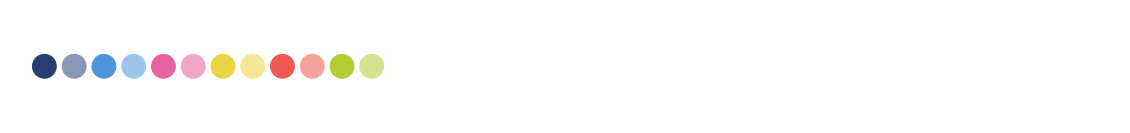

In [47]:
cols = []
colors = [(98, 93, 78), (14, 79, 58), (75, 90, 85), (347, 72, 60), (246, 79, 60), (257, 71, 27)]

for col in colors:
    pal = sns.light_palette(col, input="husl", n_colors=3)
    for rgb in pal[1:]:
        cols.append(rgb)
cols.reverse()
fig, ax = plt.subplots(figsize=(20, 5))
for i, c in enumerate(cols):
    ax.add_artist(plt.Circle((i, 0), 0.4, color=c))    
    ax.set_axis_off()
    ax.set_aspect(1)
    plt.xlim(-1.25,36.25)
    plt.ylim(-2,2)

In [7]:
color = (257, 71, 27)  # here for arrow, title, scalebar

# plotting
c = husl.husl_to_hex(*color)

cmap = ListedColormap(cols)  

ax = buildings.plot('year', categorical=True, figsize=(30, 30), cmap=cmap, legend=True,
                   legend_kwds=dict(loc='center right', frameon=False))
ax.set_axis_off()


# add scalebar
scalebar = ScaleBar(dx=1,
                    color=c,
                    location=1,
                    height_fraction=0.001,
                    #fixed_value=1000,
                    label='historical period',
                    label_loc='bottom'
                    )
ax.add_artist(scalebar)

# add arrow
north_arrow(plt.gcf(), ax, 0, legend_size=(.04,.04), outline=1, edgecolor=c, facecolor=c)
for ext in ['pdf', 'png']:
     plt.savefig('figures/AMS_origin.' + ext, bbox_inches='tight')

SyntaxError: 'break' outside loop (<ipython-input-7-4db9ff3ac36f>, line 2)

In [8]:
color = (257, 71, 27)  # here for arrow, title, scalebar

# plotting
c = husl.husl_to_hex(*color)

cmap = ListedColormap(cols)  

ax = buildings.cx[118000:126000, 480000:490000].plot('year', categorical=True, figsize=(30, 30), cmap=cmap, legend=True,
                   legend_kwds=dict(loc='center right', frameon=False))
ax.set_axis_off()


# add scalebar
scalebar = ScaleBar(dx=1,
                    color=c,
                    location=1,
                    height_fraction=0.001,
                    #fixed_value=1000,
                    label='historical period',
                    label_loc='bottom'
                    )
ax.add_artist(scalebar)

# add arrow
north_arrow(plt.gcf(), ax, 0, legend_size=(.04,.04), outline=1, edgecolor=c, facecolor=c)
for ext in ['pdf', 'png']:
    plt.savefig('figures/AMS_origin_detail.' + ext, bbox_inches='tight')

SyntaxError: 'break' outside loop (<ipython-input-8-304234a89a7f>, line 2)

In [50]:
import numpy as np

def show_values_on_bars(axs):
    def _show_on_single_plot(ax):        
        for p in ax.patches:
            _x = p.get_x() + p.get_width() / 2
            _y = p.get_y() + p.get_height() + 0.02
            value = '{:.2f}'.format(p.get_height())
            ax.text(_x, _y, value, ha="center") 

    if isinstance(axs, np.ndarray):
        for idx, ax in np.ndenumerate(axs):
            _show_on_single_plot(ax)
    else:
        _show_on_single_plot(axs)

pal = [husl.husl_to_hex(*color) for color in colors]

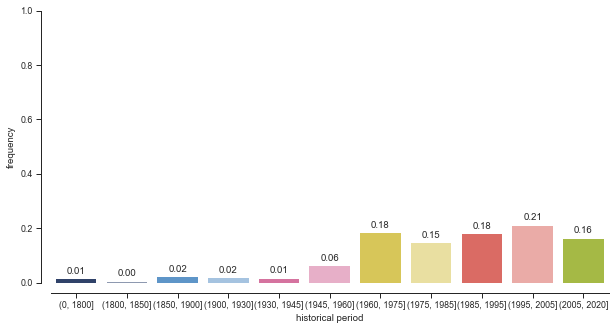

In [60]:
# historical core
data = joined.loc[joined['cluster'].isin([8])]['year'].value_counts(sort=False, normalize=True)

sns.set(context="paper", style="ticks", rc={'patch.force_edgecolor': False})
fig, ax = plt.subplots(figsize=(10, 5))
sns.barplot(ax=ax, x=data.index, y=data, order=data.index, palette=cols)
sns.despine(offset=10)
plt.ylabel('frequency')
plt.xlabel('historical period')
plt.ylim(0, 1)
show_values_on_bars(ax)

In [16]:
import scipy.stats as ss
import numpy as np

def cramers_v(x, y):
    confusion_matrix = pd.crosstab(x,y)
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2-((k-1)*(r-1))/(n-1))
    rcorr = r-((r-1)**2)/(n-1)
    kcorr = k-((k-1)**2)/(n-1)
    return np.sqrt(phi2corr/min((kcorr-1),(rcorr-1)))

In [17]:
cramers_v(joined.cluster, joined.year)

0.35271919336786556

In [31]:
confusion_matrix = pd.crosstab(joined.cluster, joined.year)

In [32]:
chi, p, dof, exp = ss.chi2_contingency(confusion_matrix)

In [33]:
p

0.0

In [37]:
chi

312903.3126042255

In [38]:
dof

290

In [39]:
ss.chi2_contingency(confusion_matrix)

(312903.3126042255,
 0.0,
 290,
 array([[3.43229803e+02, 1.13616053e+01, 4.26548242e+02, 1.69815004e+03,
         8.12413347e+02, 1.25863942e+03, 1.40692594e+03, 9.64994632e+02,
         1.34730680e+03, 8.18191758e+02, 7.23238411e+02],
        [9.10323382e+02, 3.01335575e+01, 1.13130280e+03, 4.50387956e+03,
         2.15470469e+03, 3.33819757e+03, 3.73148710e+03, 2.55938491e+03,
         3.57336358e+03, 2.17003035e+03, 1.91819251e+03],
        [2.46253652e+02, 8.15149730e+00, 3.06031299e+02, 1.21835472e+03,
         5.82874075e+02, 9.03023432e+02, 1.00941308e+03, 6.92345042e+02,
         9.66638725e+02, 5.87019854e+02, 5.18894626e+02],
        [1.19750853e+02, 3.96399706e+00, 1.48820164e+02, 5.92474529e+02,
         2.83446222e+02, 4.39131866e+02, 4.90868158e+02, 3.36680932e+02,
         4.70067390e+02, 2.85462276e+02, 2.52333613e+02],
        [3.22309262e+02, 1.06690929e+01, 4.00549277e+02, 1.59464442e+03,
         7.62895135e+02, 1.18192284e+03, 1.32117100e+03, 9.06176286e+02,
      

In [25]:
confusion_matrix = pd.crosstab(joined.cluster, joined.year)
print(confusion_matrix.to_markdown())

|   cluster |   (0, 1800] |   (1800, 1850] |   (1850, 1900] |   (1900, 1930] |   (1930, 1945] |   (1945, 1960] |   (1960, 1975] |   (1975, 1985] |   (1985, 1995] |   (1995, 2005] |   (2005, 2020] |
|----------:|------------:|---------------:|---------------:|---------------:|---------------:|---------------:|---------------:|---------------:|---------------:|---------------:|---------------:|
|         0 |         827 |              4 |           3012 |           2560 |            484 |            154 |             86 |            311 |            471 |           1048 |            854 |
|         1 |           2 |              1 |             23 |            752 |            748 |           5678 |           5841 |           2048 |           5582 |           2136 |           3210 |
|         2 |         761 |             10 |            625 |           2307 |            839 |            431 |            207 |            495 |            593 |            590 |            181 |
|         